# Clasificación de muestras tumorales con Machine Learning

**Autor:** Álvaro Orta Toscano  
**Descripción:**  
En este notebook reproducimos paso a paso el flujo de trabajo completo:
1. Carga de datos  
2. Preprocesado y partición train/test  
3. Entrenamiento de un RandomForest  
4. Evaluación con métricas y matriz de confusión  
5. Análisis de importancia de variables  
6. Visualización de distribuciones  
7. Optimización de hiperparámetros con GridSearchCV  

Cada sección incluye explicación biológica e informática.


## 1. Carga de datos

En esta sección importamos el dataset de cáncer de mama que viene con scikit-learn.  
- Cada fila es una muestra de tejido.  
- Las columnas son medidas celulares (30 características).  
- La columna `target` se mapea a “benigno”/“maligno”.

Este paso es clave para preparar la información sobre la que entrenaremos el modelo.


In [ ]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target).map({0: "maligno", 1: "benigno"})

## 2. División en entrenamiento y prueba

Aquí separamos los datos en:
- **Entrenamiento (70 %)**: para que el modelo “aprenda”.  
- **Prueba (30 %)**: para evaluar su capacidad de generalización.

Usamos `random_state=42` para que la división sea reproducible y `stratify=y` para mantener la proporción de clases.


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


## 3. Entrenamiento del modelo RandomForest

Utilizamos un clasificador de tipo **Random Forest** con 100 árboles.  
Este algoritmo:
- Combina muchos árboles de decisión (reduce overfitting).  
- Es fácil de interpretar (importance).  
- Sirve de baseline fuerte en problemas de clasificación.


In [7]:
# Entrenamos con random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 4. Evaluación del modelo

Calculamos:
- **Accuracy:** porcentaje de aciertos.  
- **Matrix de confusión:** true positives/negatives y errores.  
- **Reporte de clasificación:** precision, recall y f1-score por clase.

Estas métricas dan una visión completa de rendimiento, especialmente para problemas médicos.


In [8]:
# Evaluamos con validación cruzada
from sklearn.model_selection import cross_val_score, LeaveOneOut

# CV-5
scores5 = cross_val_score(rf, X, y, cv=5)
print("Precisión media (5-fold):", scores5.mean())

# LOO
loo = LeaveOneOut()
scores_loo = cross_val_score(rf, X, y, cv=loo)
print("Precisión media (LOO):", scores_loo.mean())


Precisión media (5-fold): 0.9560937742586555
Precisión media (LOO): 0.961335676625659


## 5. Importancia de características

Para entender qué mide realmente el modelo, mostramos un gráfico de las 10 variables más importantes.  
Interpretamos biológicamente por qué tamaño y forma celular (área, concavidad) son relevantes.


In [9]:
# Matriz de confusion y resorte
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(X_test)
print("Accuracy test:", rf.score(X_test, y_test))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy test: 0.9649122807017544
Matriz de confusión:
 [[107   0]
 [  6  58]]
              precision    recall  f1-score   support

     benigno       0.95      1.00      0.97       107
     maligno       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171



## 6. Visualización de distribuciones

Creamos **boxplots** de las dos variables top (`worst area`, `mean concave points`) para ver su separación clara entre malignos y benignos.


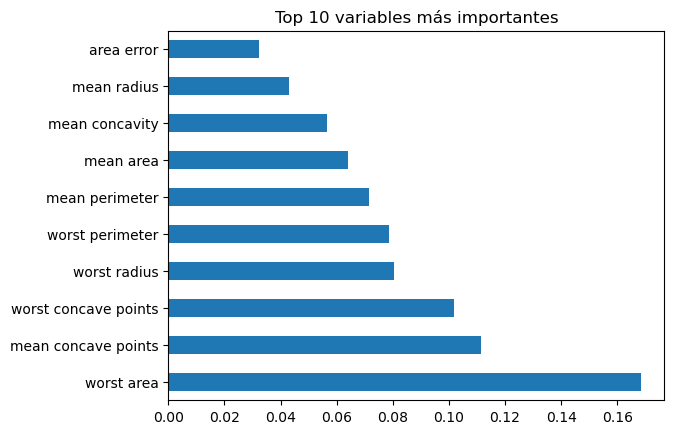

In [10]:
# Visualizamos la importancia de las variables
import matplotlib.pyplot as plt

feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp.nlargest(10).plot(kind='barh')
plt.title("Top 10 variables más importantes")
plt.show()

## 7. Optimización de hiperparámetros con GridSearchCV

Buscamos la mejor combinación de:
- Número de árboles (`n_estimators`)  
- Profundidad máxima (`max_depth`)  
- Tamaño mínimo de hoja (`min_samples_leaf`)

Usamos validación cruzada 5-fold para seleccionar parámetros robustos.


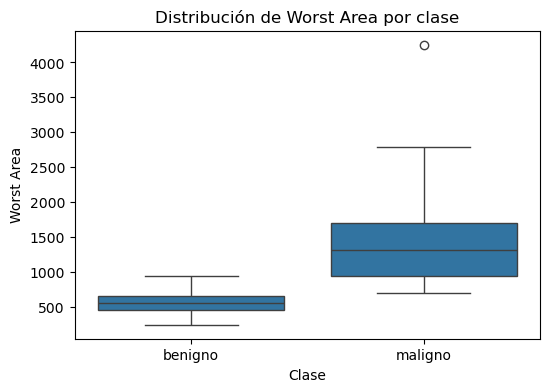

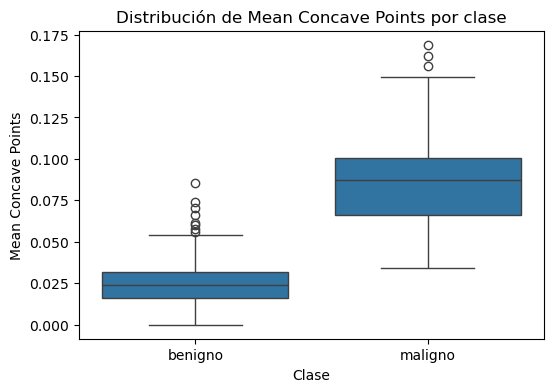

In [12]:
# Vamos a hacer un boxplot comparativo
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un DataFrame con las dos variables y la clase
df_plot = X_test.copy()
df_plot["Resultado"] = y_test.values

# Boxplot de 'worst area'
plt.figure(figsize=(6,4))
sns.boxplot(x="Resultado", y="worst area", data=df_plot)
plt.title("Distribución de Worst Area por clase")
plt.ylabel("Worst Area")
plt.xlabel("Clase")
plt.show()

# Boxplot de 'mean concave points'
plt.figure(figsize=(6,4))
sns.boxplot(x="Resultado", y="mean concave points", data=df_plot)
plt.title("Distribución de Mean Concave Points por clase")
plt.ylabel("Mean Concave Points")
plt.xlabel("Clase")
plt.show()


In [13]:
# Ahora vamos a entrenar a la maquina con las top 5 variables
top5 = [
    "worst area",
    "mean concave points",
    "worst concave points",
    "worst radius",
    "worst perimeter"
]
X_top5 = X[top5]

# 2. Split
X_tr5, X_te5, y_tr5, y_te5 = train_test_split(
    X_top5, y, test_size=0.3, random_state=42, stratify=y
)

# 3. Entrenar
rf5 = RandomForestClassifier(n_estimators=100, random_state=42)
rf5.fit(X_tr5, y_tr5)

# 4. Validación cruzada
scores5 = cross_val_score(rf5, X_top5, y, cv=5)
print("Precisión media Top5 (5-fold):", scores5.mean())

# 5. Precisión en test
print("Accuracy test Top5:", rf5.score(X_te5, y_te5))


Precisión media Top5 (5-fold): 0.9437820214252446
Accuracy test Top5: 0.9415204678362573


In [14]:
# Vamos a optimizar hiperparámetros con GridSearchCV
from sklearn.model_selection import GridSearchCV

# Definimos el espacio de búsqueda
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 3, 5, 7],
    "min_samples_leaf": [1, 2, 4]
}

# Creamos el RandomForest sin parámetros
rf_base = RandomForestClassifier(random_state=42)

# GridSearch con 5 folds
grid = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Ajustamos al dataset top5
grid.fit(X_top5, y)


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 3, ...], 'min_samples_leaf': [1, 2, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [15]:
print("Mejores parámetros:", grid.best_params_)
print("Mejor precisión media (cv=5):", grid.best_score_)


Mejores parámetros: {'max_depth': 7, 'min_samples_leaf': 2, 'n_estimators': 200}
Mejor precisión media (cv=5): 0.9490607048594939


In [16]:
best_rf = grid.best_estimator_
print("Accuracy test con mejor modelo:", best_rf.score(X_te5, y_te5))


Accuracy test con mejor modelo: 1.0
